In [1]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from datetime import datetime, timedelta

# -----------------------------
# 0) Reproducibility
# -----------------------------
SEED = 42
rng = np.random.default_rng(SEED)

# -----------------------------
# 1) "Catalog" of Rockstar-style titles (synthetic assumptions)
# -----------------------------
# Note: Titles are used as labels; numbers are simulated.
# Entity references (for your writeup): :contentReference[oaicite:0]{index=0}
# Games: :contentReference[oaicite:1]{index=1}, :contentReference[oaicite:2]{index=2}

@dataclass
class GameSpec:
    game: str
    franchise: str
    release_date: str  # YYYY-MM-DD
    base_price: float
    monetization: str  # "premium", "premium+mtx"
    genre: str
    base_demand: float  # relative demand scalar
    quality_score: float  # 0..100 (used to link design -> sales)

games = [
    GameSpec("Grand Theft Auto V", "GTA", "2013-09-17", 29.99, "premium+mtx", "Open-world Action", 1.80, 92),
    GameSpec("Red Dead Redemption 2", "Red Dead", "2018-10-26", 39.99, "premium+mtx", "Open-world Western", 1.30, 96),
    GameSpec("L.A. Noire", "LA Noire", "2011-05-17", 19.99, "premium", "Detective/Action", 0.55, 83),
    GameSpec("Max Payne 3", "Max Payne", "2012-05-15", 14.99, "premium", "Shooter", 0.50, 81),
    GameSpec("Bully", "Bully", "2006-10-17", 9.99, "premium", "Action/Adventure", 0.40, 87),
]

games_df = pd.DataFrame([g.__dict__ for g in games])
games_df["release_date"] = pd.to_datetime(games_df["release_date"])

# -----------------------------
# 2) Design analysis fields (Mechanics / Dynamics / Aesthetics / Narrative / Technical)
#    These are numeric proxies to let you run correlations, regression, etc.
# -----------------------------
def clamp(x, lo=0, hi=100):
    return float(max(lo, min(hi, x)))

def make_design_profile(quality_score: float):
    # Build a plausible, internally consistent profile from a "quality_score"
    # You can replace these rules with your own rubric.
    mechanics = clamp(rng.normal(quality_score, 6))
    dynamics  = clamp(rng.normal(quality_score - 2, 7))
    aesthetics = clamp(rng.normal(quality_score + 1, 5))
    narrative = clamp(rng.normal(quality_score - 1, 8))
    technical = clamp(rng.normal(quality_score - 3, 9))
    return mechanics, dynamics, aesthetics, narrative, technical

profiles = games_df["quality_score"].apply(make_design_profile)
games_df[["mechanics_score","dynamics_score","aesthetics_score","narrative_score","technical_score"]] = pd.DataFrame(profiles.tolist())

# Add a short "core loop" label for analysis text
core_loops = {
    "Open-world Action": "Explore → Missions → Rewards → Upgrade/Unlock",
    "Open-world Western": "Explore → Story/Missions → Loot/Progress → Camp/Upgrades",
    "Detective/Action": "Investigate → Interrogate → Solve Cases → Unlock Story",
    "Shooter": "Combat → Setpieces → Weapons/Skills → New Challenges",
    "Action/Adventure": "School-life Quests → Mischief/Progress → Unlock Areas"
}
games_df["core_gameplay_loop"] = games_df["genre"].map(core_loops)

# -----------------------------
# 3) Demographics dimensions
# -----------------------------
REGIONS = ["North America", "Europe", "UK/Ireland", "LATAM", "APAC"]
PLATFORMS = ["PC", "PlayStation", "Xbox"]
CHANNELS = ["Digital", "Physical"]
AGE_GROUPS = ["13-17", "18-24", "25-34", "35-44", "45+"]
GENDERS = ["Woman", "Man", "Non-binary/Other"]
INCOME = ["Low", "Mid", "High"]

# Simple weights (edit freely)
region_w = np.array([0.30, 0.22, 0.08, 0.12, 0.28])
platform_w = np.array([0.34, 0.38, 0.28])
channel_w = np.array([0.84, 0.16])

age_w = np.array([0.10, 0.27, 0.33, 0.20, 0.10])
gender_w = np.array([0.34, 0.62, 0.04])
income_w = np.array([0.30, 0.52, 0.18])

def weighted_choice(options, weights, size):
    idx = rng.choice(len(options), size=size, p=weights)
    return np.array(options, dtype=object)[idx]

# -----------------------------
# 4) Sales & profit logic (weekly)
# -----------------------------
def seasonality_multiplier(week_of_year: int):
    # Holiday + summer bumps (very common in real markets)
    # Smooth-ish via gaussians
    holiday = np.exp(-0.5 * ((week_of_year - 48) / 4.5) ** 2)  # late Nov/Dec
    summer  = np.exp(-0.5 * ((week_of_year - 28) / 5.5) ** 2)  # summer sales
    base = 1.0 + 0.35 * holiday + 0.18 * summer
    return base

def weeks_since_release(week_start: pd.Timestamp, release_date: pd.Timestamp):
    return max(0, int((week_start - release_date).days // 7))

def demand_decay(ws: int):
    # Big launch, then decay; older games stabilize (long tail)
    # Using a two-phase curve
    if ws < 8:
        return 2.4 - 0.12 * ws  # launch window
    return 0.9 * np.exp(-0.015 * (ws - 8)) + 0.35  # long tail floor

def discount_rate(ws: int, monetization: str):
    # Older titles discount more often; premium+mtx discounts to bring players in
    base = 0.05 + min(0.55, ws * 0.003)
    if monetization == "premium+mtx":
        base += 0.05
    # Add occasional promotion spikes
    promo = 0.0
    if rng.random() < 0.08:  # ~8% of weeks get a promotion bump
        promo = rng.uniform(0.10, 0.35)
    return float(min(0.80, base + promo))

def platform_fee_rate(channel: str):
    # Roughly: digital storefront fees vs physical distribution cuts
    if channel == "Digital":
        return 0.30
    return 0.18

def support_cost_per_unit(monetization: str):
    # Premium+mtx tends to have higher ongoing service costs
    return 1.10 if monetization == "premium+mtx" else 0.60

def mtx_attach_rate(ws: int, age_group: str):
    # Who spends extra & when (simple behavioral model)
    # Generally: peak engagement early-mid lifecycle; younger cohorts slightly higher attach.
    age_boost = {"13-17": 1.12, "18-24": 1.08, "25-34": 1.00, "35-44": 0.92, "45+": 0.85}[age_group]
    lifecycle = 0.18 * np.exp(-0.01 * ws) + 0.06  # decays, keeps a floor
    return float(min(0.35, lifecycle * age_boost))

def mtx_arppu(age_group: str, income: str):
    # Average revenue per paying user (synthetic)
    age_factor = {"13-17": 0.8, "18-24": 1.0, "25-34": 1.1, "35-44": 1.05, "45+": 0.95}[age_group]
    income_factor = {"Low": 0.75, "Mid": 1.0, "High": 1.35}[income]
    return float(rng.lognormal(mean=np.log(14), sigma=0.35) * age_factor * income_factor)

def units_sold_model(game_row, region, platform, channel, week_start):
    ws = weeks_since_release(week_start, game_row["release_date"])
    woy = int(week_start.isocalendar().week)

    # Demand baseline
    qual = game_row["quality_score"] / 100.0
    design_lift = (0.35 * (game_row["mechanics_score"]/100.0) +
                   0.25 * (game_row["dynamics_score"]/100.0) +
                   0.20 * (game_row["aesthetics_score"]/100.0) +
                   0.10 * (game_row["narrative_score"]/100.0) +
                   0.10 * (game_row["technical_score"]/100.0))

    # Region/platform/channel scalars (editable knobs)
    region_scalar = {"North America": 1.10, "Europe": 1.00, "UK/Ireland": 0.95, "LATAM": 0.65, "APAC": 0.90}[region]
    platform_scalar = {"PC": 0.95, "PlayStation": 1.05, "Xbox": 0.98}[platform]
    channel_scalar = {"Digital": 1.05, "Physical": 0.60}[channel]

    seasonal = seasonality_multiplier(woy)
    decay = demand_decay(ws)

    # Update spikes for live-service style titles
    update_spike = 1.0
    if game_row["monetization"] == "premium+mtx" and rng.random() < 0.06:
        update_spike += rng.uniform(0.10, 0.45)

    # Convert to units (Poisson for count data)
    # base_demand drives overall scale; design_lift ties your MDA analysis to outcomes
    lam = 2200 * game_row["base_demand"] * (0.65 + 0.7*qual) * (0.70 + 0.8*design_lift)
    lam *= region_scalar * platform_scalar * channel_scalar * seasonal * decay * update_spike

    # Keep reasonable
    lam = max(5, lam)
    units = int(rng.poisson(lam))
    return units, ws

# -----------------------------
# 5) Build weekly dataset
# -----------------------------
start_date = pd.Timestamp("2024-01-01")
end_date   = pd.Timestamp("2025-12-29")  # ~2 years of weeks

weeks = pd.date_range(start=start_date, end=end_date, freq="W-MON")

rows = []
for week_start in weeks:
    for _, g in games_df.iterrows():
        # Skip weeks before release (optional)
        if week_start < g["release_date"]:
            continue

        # Sample multiple segments per game-week to create demographic richness
        segments = 40  # increase for bigger dataset
        regions = weighted_choice(REGIONS, region_w, segments)
        platforms = weighted_choice(PLATFORMS, platform_w, segments)
        channels = weighted_choice(CHANNELS, channel_w, segments)
        ages = weighted_choice(AGE_GROUPS, age_w, segments)
        genders = weighted_choice(GENDERS, gender_w, segments)
        incomes = weighted_choice(INCOME, income_w, segments)

        for region, platform, channel, age, gender, income in zip(regions, platforms, channels, ages, genders, incomes):
            units, ws = units_sold_model(g, region, platform, channel, week_start)

            disc = discount_rate(ws, g["monetization"])
            price = g["base_price"] * (1 - disc)

            game_rev = units * price

            # MTX revenue (only if premium+mtx)
            if g["monetization"] == "premium+mtx":
                attach = mtx_attach_rate(ws, age)
                paying_users = int(round(units * attach))
                mtx_rev = paying_users * mtx_arppu(age, income)
            else:
                paying_users = 0
                mtx_rev = 0.0

            gross_rev = game_rev + mtx_rev

            # Costs (synthetic but structured)
            fee_rate = platform_fee_rate(channel)
            platform_fees = gross_rev * fee_rate

            cogs = units * (2.20 if channel == "Physical" else 0.35)  # manufacturing/shipping vs bandwidth
            support = units * support_cost_per_unit(g["monetization"])

            # "Marketing" amortized: heavier near launch window
            marketing = 0.0
            if ws < 12:
                marketing = gross_rev * rng.uniform(0.04, 0.10)
            else:
                marketing = gross_rev * rng.uniform(0.005, 0.02)

            total_cost = platform_fees + cogs + support + marketing
            profit = gross_rev - total_cost

            rows.append({
                "week_start": week_start,
                "game": g["game"],
                "franchise": g["franchise"],
                "genre": g["genre"],
                "monetization": g["monetization"],
                "weeks_since_release": ws,

                # Demographics / segment
                "region": region,
                "platform": platform,
                "channel": channel,
                "age_group": age,
                "gender": gender,
                "income_bracket": income,

                # Design analysis proxies (MDA + narrative + technical)
                "core_gameplay_loop": g["core_gameplay_loop"],
                "mechanics_score": g["mechanics_score"],
                "dynamics_score": g["dynamics_score"],
                "aesthetics_score": g["aesthetics_score"],
                "narrative_score": g["narrative_score"],
                "technical_score": g["technical_score"],

                # Commerce
                "discount_rate": disc,
                "net_price": price,
                "units_sold": units,
                "game_revenue": game_rev,
                "mtx_paying_users": paying_users,
                "mtx_revenue": mtx_rev,
                "gross_revenue": gross_rev,
                "platform_fees": platform_fees,
                "cogs": cogs,
                "support_cost": support,
                "marketing_cost": marketing,
                "profit": profit
            })

df = pd.DataFrame(rows)

df.head(10), df.shape


(  week_start                game  ... marketing_cost        profit
 0 2024-01-01  Grand Theft Auto V  ...     207.236396  20244.526238
 1 2024-01-01  Grand Theft Auto V  ...     295.337963  16960.446607
 2 2024-01-01  Grand Theft Auto V  ...     216.393248  12959.010504
 3 2024-01-01  Grand Theft Auto V  ...     209.148117  18194.027657
 4 2024-01-01  Grand Theft Auto V  ...     184.282051   5408.555946
 5 2024-01-01  Grand Theft Auto V  ...     324.280473  14186.987333
 6 2024-01-01  Grand Theft Auto V  ...     204.174986  16278.707098
 7 2024-01-01  Grand Theft Auto V  ...     314.801013  18132.886736
 8 2024-01-01  Grand Theft Auto V  ...     365.198861  16841.804894
 9 2024-01-01  Grand Theft Auto V  ...     401.954519  17565.321337
 
 [10 rows x 30 columns],
 (21000, 30))

In [2]:
# Weekly rollup by game
weekly_game = (df.groupby(["week_start","game"], as_index=False)
                 .agg(units_sold=("units_sold","sum"),
                      gross_revenue=("gross_revenue","sum"),
                      profit=("profit","sum"),
                      mtx_revenue=("mtx_revenue","sum"),
                      avg_discount=("discount_rate","mean")))

# Yearly rollup by game
df["year"] = df["week_start"].dt.year
yearly_game = (df.groupby(["year","game"], as_index=False)
                 .agg(units_sold=("units_sold","sum"),
                      gross_revenue=("gross_revenue","sum"),
                      profit=("profit","sum"),
                      mtx_revenue=("mtx_revenue","sum"),
                      avg_discount=("discount_rate","mean")))

weekly_game.head(), yearly_game.head()


(  week_start                   game  ...   mtx_revenue  avg_discount
 0 2024-01-01                  Bully  ...      0.000000      0.613569
 1 2024-01-01     Grand Theft Auto V  ...  92928.782788      0.657384
 2 2024-01-01             L.A. Noire  ...      0.000000      0.615000
 3 2024-01-01            Max Payne 3  ...      0.000000      0.613553
 4 2024-01-01  Red Dead Redemption 2  ...  80994.952219      0.667300
 
 [5 rows x 7 columns],
    year                   game  ...   mtx_revenue  avg_discount
 0  2024                  Bully  ...  0.000000e+00      0.613808
 1  2024     Grand Theft Auto V  ...  5.083963e+06      0.661813
 2  2024             L.A. Noire  ...  0.000000e+00      0.616713
 3  2024            Max Payne 3  ...  0.000000e+00      0.613770
 4  2024  Red Dead Redemption 2  ...  4.539006e+06      0.660777
 
 [5 rows x 7 columns])

In [3]:
# Who buys most units (by age group)
units_by_age = (df.groupby("age_group", as_index=False)
                  .agg(units_sold=("units_sold","sum"),
                       gross_revenue=("gross_revenue","sum"),
                       profit=("profit","sum"))
                  .sort_values("units_sold", ascending=False))

# Who drives MTX revenue (age x income)
mtx_by_age_income = (df[df["mtx_revenue"] > 0]
                     .groupby(["age_group","income_bracket"], as_index=False)
                     .agg(mtx_revenue=("mtx_revenue","sum"),
                          paying_users=("mtx_paying_users","sum"))
                     .sort_values("mtx_revenue", ascending=False))

units_by_age, mtx_by_age_income.head(10)


(  age_group  units_sold  gross_revenue        profit
 2     25-34     9230112   9.856821e+07  5.523101e+07
 1     18-24     7607215   8.125963e+07  4.551722e+07
 3     35-44     5508542   5.796098e+07  3.238128e+07
 4       45+     2861687   3.000540e+07  1.673600e+07
 0     13-17     2741854   2.929805e+07  1.638842e+07,
    age_group income_bracket   mtx_revenue  paying_users
 8      25-34            Mid  3.385279e+06        210572
 5      18-24            Mid  2.806555e+06        192649
 11     35-44            Mid  1.765716e+06        112673
 6      25-34           High  1.698811e+06         75174
 7      25-34            Low  1.560136e+06        127718
 3      18-24           High  1.338232e+06         66688
 4      18-24            Low  1.217967e+06        110615
 2      13-17            Mid  8.925135e+05         74514
 10     35-44            Low  8.383257e+05         70518
 9      35-44           High  8.279159e+05         39814)

In [4]:
# Retention proxy: average units sold after 26+ weeks since release
retention = (df[df["weeks_since_release"] >= 26]
             .groupby("game", as_index=False)
             .agg(long_tail_units=("units_sold","mean"),
                  avg_profit=("profit","mean"),
                  dynamics=("dynamics_score","mean"),
                  technical=("technical_score","mean")))

retention.sort_values("long_tail_units", ascending=False).head(10)


,game,long_tail_units,avg_profit,dynamics,technical
1,Grand Theft Auto V,2660.953810,16217.725288,82.720111,71.440683
4,Red Dead Redemption 2,2041.667857,17426.759544,94.894883,85.322605
2,L.A. Noire,752.725476,3186.241601,86.444544,84.207584
3,Max Payne 3,648.540000,1896.369531,81.581255,77.550667
0,Bully,550.734286,857.170778,80.233493,80.145050


In [5]:
# Compare monetization models post-launch
post_launch = df[df["weeks_since_release"] >= 12].copy()

monetization_compare = (post_launch.groupby("monetization", as_index=False)
                        .agg(avg_weekly_units=("units_sold","mean"),
                             avg_weekly_profit=("profit","mean"),
                             avg_weekly_rev=("gross_revenue","mean"),
                             avg_mtx_share=("mtx_revenue","mean")))

monetization_compare


,monetization,avg_weekly_units,avg_weekly_profit,avg_weekly_rev,avg_mtx_share
0,premium,650.666587,1979.927303,3883.369841,0.000000
1,premium+mtx,2351.310833,16822.242416,29543.072301,2218.632293


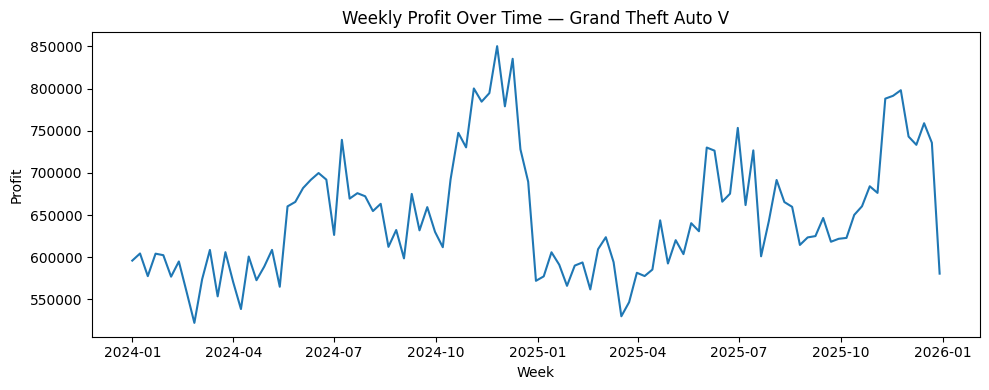

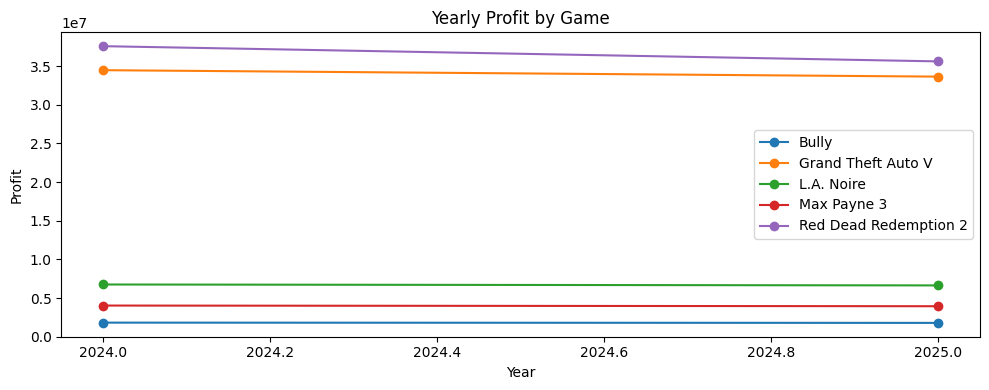

In [6]:
import matplotlib.pyplot as plt

# Profit over time for a single game
gname = "Grand Theft Auto V"
tmp = weekly_game[weekly_game["game"] == gname]

plt.figure(figsize=(10,4))
plt.plot(tmp["week_start"], tmp["profit"])
plt.title(f"Weekly Profit Over Time — {gname}")
plt.xlabel("Week")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()

# Yearly profit comparison across games
pivot = yearly_game.pivot(index="year", columns="game", values="profit").fillna(0)

plt.figure(figsize=(10,4))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", label=col)
plt.title("Yearly Profit by Game")
plt.xlabel("Year")
plt.ylabel("Profit")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
df.to_csv("rockstar_style_sales_weekly_segments.csv", index=False)
weekly_game.to_csv("rockstar_style_weekly_rollup.csv", index=False)
yearly_game.to_csv("rockstar_style_yearly_rollup.csv", index=False)

"Saved CSVs in the current notebook directory."


'Saved CSVs in the current notebook directory.'